In [1]:
import numpy as np
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import copy
import time

In [2]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2['ATR']

def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [3]:
import os
os.chdir('./../../')

In [4]:
from Resources.APIKeys import APIKeys
ts = TimeSeries(key=APIKeys.alpha_vantage, output_format='pandas')

In [5]:
tickers = ["MSFT","AAPL","FB","AMZN","INTC", "CSCO","VZ","IBM","TSLA","AMD"]

In [6]:
ohlc_intraday = {} # directory with ohlc value for each stock   
api_call_count = 1
start_time = time.time()
for ticker in tickers:
    data = ts.get_intraday(symbol=ticker,interval='5min', outputsize='full')[0]
    api_call_count+=1
    data.columns = ["Open","High","Low","Close","Volume"]
    data = data.iloc[::-1]
    data = data.between_time('09:35', '16:00') #remove data outside regular trading hours
    ohlc_intraday[ticker] = data
    if api_call_count==5:
        api_call_count = 1
        time.sleep(60 - ((time.time() - start_time) % 60.0))

tickers = ohlc_intraday.keys() # redefine tickers variable after removing any tickers with corrupted data

In [7]:
# calculating ATR and rolling max price for each stock and consolidating this info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    print("calculating ATR and rolling max price for ",ticker)
    ohlc_dict[ticker]["ATR"] = ATR(ohlc_dict[ticker],20)
    ohlc_dict[ticker]["roll_max_cp"] = ohlc_dict[ticker]["High"].rolling(20).max()
    ohlc_dict[ticker]["roll_min_cp"] = ohlc_dict[ticker]["Low"].rolling(20).min()
    ohlc_dict[ticker]["roll_max_vol"] = ohlc_dict[ticker]["Volume"].rolling(20).max()
    ohlc_dict[ticker].dropna(inplace=True)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = [0]

calculating ATR and rolling max price for  MSFT
calculating ATR and rolling max price for  AAPL
calculating ATR and rolling max price for  FB
calculating ATR and rolling max price for  AMZN
calculating ATR and rolling max price for  INTC
calculating ATR and rolling max price for  CSCO
calculating ATR and rolling max price for  VZ
calculating ATR and rolling max price for  IBM
calculating ATR and rolling max price for  TSLA
calculating ATR and rolling max price for  AMD


In [8]:
# identifying signals and calculating daily return (stop loss factored in)
for ticker in tickers:
    print("calculating returns for ",ticker)
    for i in range(1,len(ohlc_dict[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            if ohlc_dict[ticker]["Low"][i]<ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append(((ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1])/ohlc_dict[ticker]["Close"][i-1])-1)
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
                
        elif tickers_signal[ticker] == "Sell":
            if ohlc_dict[ticker]["High"][i]>ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/(ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]))-1)
            elif ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
                
    ohlc_dict[ticker]["ret"] = np.array(tickers_ret[ticker])

calculating returns for  MSFT
calculating returns for  AAPL
calculating returns for  FB
calculating returns for  AMZN
calculating returns for  INTC
calculating returns for  CSCO
calculating returns for  VZ
calculating returns for  IBM
calculating returns for  TSLA
calculating returns for  AMD


In [9]:
# calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_dict[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)
CAGR(strategy_df)
sharpe(strategy_df,0.025)
max_dd(strategy_df)  

0.009005609187712572

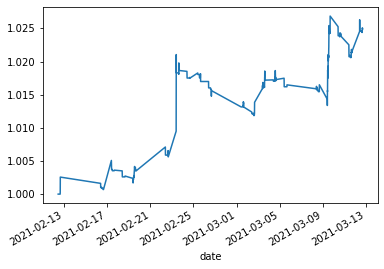

In [10]:
# vizualization of strategy return
(1+strategy_df["ret"]).cumprod().plot();

In [11]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_dict[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_dict[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_dict[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

calculating KPIs for  MSFT
calculating KPIs for  AAPL
calculating KPIs for  FB
calculating KPIs for  AMZN
calculating KPIs for  INTC
calculating KPIs for  CSCO
calculating KPIs for  VZ
calculating KPIs for  IBM
calculating KPIs for  TSLA
calculating KPIs for  AMD


,Return,Sharpe Ratio,Max Drawdown
MSFT,0.218582,2.798957,0.012145
AAPL,0.181494,1.264138,0.030317
FB,1.098673,9.516636,0.012837
AMZN,0.556197,5.097701,0.008266
INTC,-0.116828,-2.589028,0.012948
CSCO,-0.126238,-3.736189,0.011343
VZ,0.244535,2.472722,0.008220
IBM,-0.081106,-2.257131,0.013894
TSLA,2.813911,11.132371,0.058476
AMD,0.327519,2.610079,0.021991


<AxesSubplot:xlabel='date'>

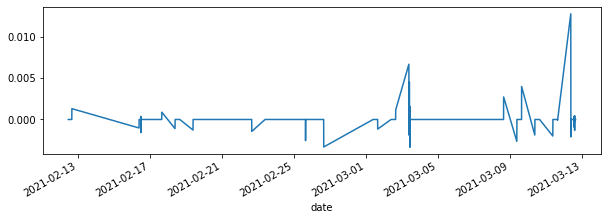

In [12]:
ohlc_dict['MSFT']['ret'].plot(figsize=(10, 3))

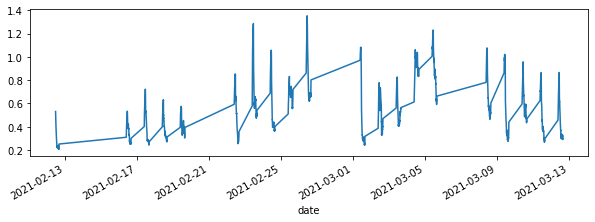

In [13]:
ohlc_dict['MSFT']['ATR'].plot(figsize=(10, 3));

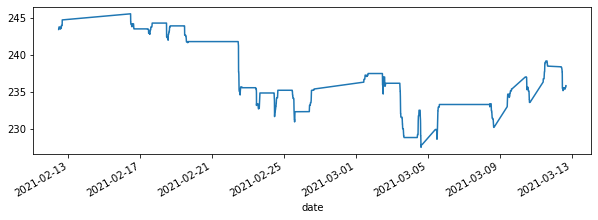

In [14]:
ohlc_dict['MSFT']['roll_max_cp'].plot(figsize=(10, 3));

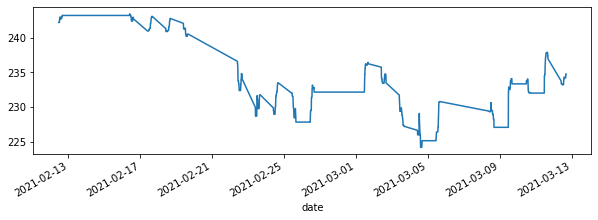

In [15]:
ohlc_dict['MSFT']['roll_min_cp'].plot(figsize=(10, 3));

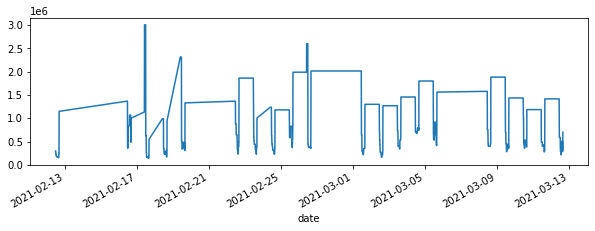

In [16]:
ohlc_dict['MSFT']['roll_max_vol'].plot(figsize=(10, 3));